<a href="TODO" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate the  `Seriously` speech separation pipeline

The purpose of this tutorial is to show how to evaluate the `seriously` speech separation pipeline, which uses the `ToTaToNet` separation model, on the tasks of speaker diarization and automatic speech recognition (ASR). You can find a description for both the pipeline and the model in [`J. Kalda, C. Pagés, R. Marxer, T. Alumäe, and H. Bredin, “PixIT: Joint Training of Speaker Diarization and Speech Separation from Real-world Multi-speaker Recordings.” arXiv, Mar. 04, 2024`](https://arxiv.org/abs/2403.02288).

## Tutorial setup

### Google Colab Setup

If you are running this tutorial on Colab, execute the following commands in order to setup the environment. These commands will install pyannote.audio, and other required dependencies.

In [ ]:
!pip install -qq speechbrain==0.5.16
!pip install -qq ipython==7.34.0
!pip install -qq ipywidgets openai-whisper whisperx meeteval

In [ ]:
!git clone https://github.com/pyannote/pyannote-audio.git
%cd pyannote-audio
!pip install -e .[separation]
%cd ..

⚠ Make sure that you switch to a GPU runtime (Runtime > Change runtime type).
If you don't, everything will be extremely slow.

⚠ Restart the runtime (Runtime > Restart session).

### Non Google Colab setup



If you are not using Colab, this tutorial assumes that:
  - `pyannote.audio[separation]` has been installed
  - `openai-whisper`, `whisperx`, and `meeteval` has been installed for ASR part


### General setup (whatever the environment)

Update `ROOT_DIR` to the path where you want to download assets used in this tutorial.


In [1]:
import os

# update ROOT_DIR according to your setup
ROOT_DIR = "path/to/pyannote-audio"

os.environ["ASSET_DIR"] = ROOT_DIR + "/tutorials/assets/seriously"

In [2]:
# create ASSET_DIR repertory
!mkdir -p ${ASSET_DIR}/sources

# Download audio files from AMI-SDM dataset used in this tutorial
!wget --continue -q -O ${ASSET_DIR}/mixture.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source0.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-0.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source1.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-1.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source2.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-2.wav
!wget --continue -q -O  ${ASSET_DIR}/sources/source3.wav https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/ES2004a/audio/ES2004a.Headset-3.wav

# Download rttm file
!wget --continue -q -O ${ASSET_DIR}/mixture.rttm https://raw.githubusercontent.com/pyannote/AMI-diarization-setup/main/only_words/rttms/test/ES2004a.rttm

# Download speaker transcriptions
!wget --continue -q -P ${ASSET_DIR}/text https://raw.githubusercontent.com/pyannote/pyannote-audio/tutorials/develop/tutorials/assets/seriously/text/mixture.A.words_joined.txt
!wget --continue -q -P ${ASSET_DIR}/text https://raw.githubusercontent.com/pyannote/pyannote-audio/tutorials/develop/tutorials/assets/seriously/text/mixture.B.words_joined.txt
!wget --continue -q -P ${ASSET_DIR}/text https://raw.githubusercontent.com/pyannote/pyannote-audio/tutorials/develop/tutorials/assets/seriously/text/mixture.C.words_joined.txt
!wget --continue -q -P ${ASSET_DIR}/text https://raw.githubusercontent.com/pyannote/pyannote-audio/tutorials/develop/tutorials/assets/seriously/text/mixture.D.words_joined.txt

In the following parts, we will work on a one-minute long chunk excerpt from a meeting involving 4 speakers.

In [3]:
from pyannote.core import notebook, Segment

segment = Segment(750, 810)
notebook.crop = segment

## Evaluation on the diarization task

In this first part of the tutorial, we are going to evaluate the pipeline in terms of diarization performance by computing the [Diarization Error Rate](https://pyannote.github.io/pyannote-metrics/reference.html?highlight=diarization%20error%20rate#diarization) (DER) on the audio mixture. To do so, we will use an implementation of the DER available in [`pyannote.metrics`](https://github.com/pyannote/pyannote-metrics).

The first step is to load the example mixture and its corresponding annotation.

In [4]:
from pyannote.database.util import load_rttm
from pyannote.audio.core.io import Audio

audio = Audio()

uri = "ES2004a" # original file name
file = os.environ["ASSET_DIR"] + "/mixture.wav"
mixture, sample_rate = audio.crop(file=file, segment=segment)

annotations = load_rttm(os.environ["ASSET_DIR"] + "/mixture.rttm")[uri]
annotations = annotations.crop(segment)

Let's take a look at the annotations, and listen the audio corresponding to the chunk.

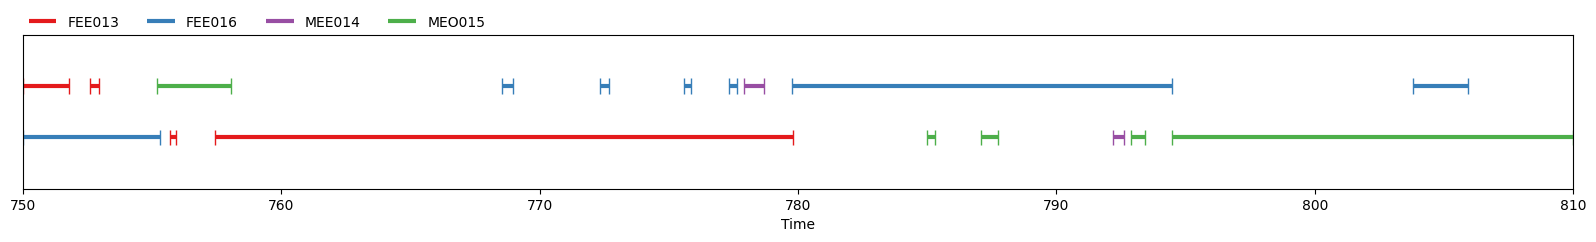

In [5]:
annotations

In [6]:
from pyannote.audio.utils.preview import listen

listen(audio_file=file, segment=segment)

Output hidden; open in https://colab.research.google.com to view.

Now that we have loaded the mixture and the corresponding annotations, we load the `serously` pipeline.

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://huggingface.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those pipelines can perfectly be downloaded for later offline use: see the end of [this tutorial](https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/applying_a_pipeline.ipynb) to learn how to do that.

To load the `seriously` pipeline used in this tutorial, you have to visit [hf.co/pyannote/speech-separation-ami-1.0](https://huggingface.co/pyannote/speech-separation-ami-1.0), accept the terms, visit [hf.co/pyannote/separation-ami-1.0](https://huggingface.co/pyannote/separation-ami-1.0) (used internally by the `seriously` pipeline), and accept the terms. Then, if you have not already done so, create a Huggingface token by going [here](https://huggingface.co/settings/tokens), and log in using `notebook_login` below:


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained("pyannote/speech-separation-ami-1.0", use_auth_token=True)

Then, instantiate the `seriously` pipeline. In this tutorial part, the pipeline hyper-parameters  were optimized for the diarization task. See [this tutorial](https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/adapting_pretrained_pipeline.ipynb) to learn how to do that.

In [9]:
pipeline.instantiate(
    {
        "segmentation": {
            "min_duration_off": 0.0,
            "threshold": 0.5,
        },
        "clustering": {
            "method": "centroid",
            "threshold": 0.68,
            "min_cluster_size": 60,
        },
        "separation": {
            "leakage_removal": True,
            "asr_collar": 0.0,
        }
    }
)

# update batch size according to your memory capacity. On Colab, you can use following values
pipeline.embedding_batch_size = 16
pipeline.segmentation_batch_size = 16

In order to speed up processing, run the pipeline on a GPU device, if available.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device=device)

The next step consists of applying the pipeline to get diarization prediction, and compare them to the annotation by computing DER.

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.audio.pipelines.utils.hook import ProgressHook

metric = DiarizationErrorRate()

# we use a ProgressHook, which will print progress for each step in the pipeline
with ProgressHook() as hook:
  # apply pipeline on the mixture file and get diarization prediction
  diarization, sources_hat = pipeline({"waveform": mixture, "sample_rate": sample_rate}, hook=hook)

Before calculating the DER, the segments produced by diarization must be temporally aligned with the annotations.

In [12]:
from pyannote.core import Annotation

shifted_diarization = Annotation(uri=uri)

for seg, track, label in diarization.itertracks(yield_label=True):
  shifted_segment = Segment(seg.start + 750., seg.end + 750.)
  shifted_diarization[shifted_segment, track] = label


We can then display the predicted speaker activity :

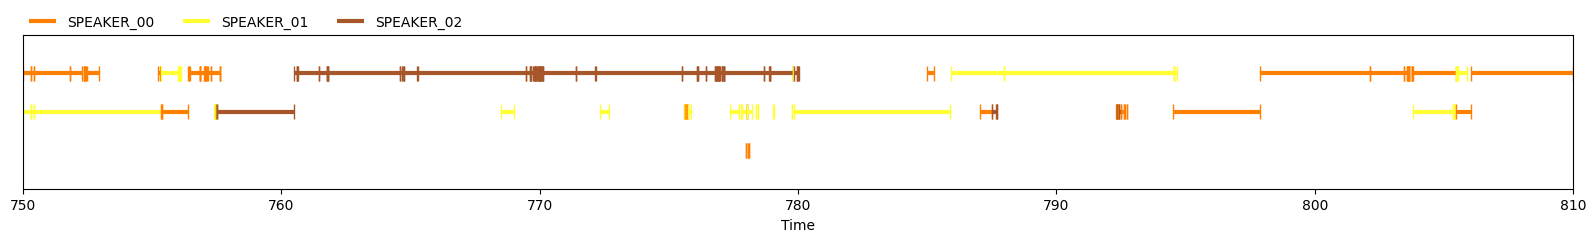

In [13]:
shifted_diarization

Finally, compute the DER and its components:

In [14]:
metric(annotations, shifted_diarization)
metric.report()

diarization error rate  total correct            false alarm  \
                             %                         %               
item                                                                   
ES2004a               11.61858  69.32  63.198  91.168494       1.932   
TOTAL                 11.61858  69.32  63.198  91.168494       1.932   

                  missed detection           confusion            
                %                          %                   %  
item                                                              
ES2004a  2.787074            2.916  4.206578     3.206  4.624928  
TOTAL    2.787074            2.916  4.206578     3.206  4.624928

## Evaluation on the ASR task


In this part, we are going to evaluate the `seriously` pipeline on Automatic Speech Recognition (ASR) task. As we saw earlier in this tutorial, the pipeline is able to provide diarization from an audio mixture passed as input. The pipeline also provides separate sources for each speaker. A [Whisper](https://github.com/openai/whisper) model is then applied to each of these sources to obtain the transcription. This is then compared with the reference transcription by calculating the [Concatenated minimum-Permutation Word Error Rate](https://arxiv.org/abs/2004.09249) (cpWER). To compute that metric, we will use the [MeetEval](https://github.com/fgnt/meeteval) toolkit.

Firstly, re-instantiate the `seriously` pipeline with the hyper-parameters optimized for the ASR task.

In [ ]:
pipeline.instantiate(
    {
        "segmentation": {"min_duration_off": 0.0, "threshold": 0.82},
        "clustering": {
            "method": "centroid",
            "min_cluster_size": 15,
            "threshold": 0.68,
        },
        "separation": {
            "leakage_removal": True,
            "asr_collar": 0.32,
        }
    }
)

Then, get the references

In [16]:
references_dir =  os.environ["ASSET_DIR"]  + "/text"

In [17]:
import whisperx
from whisper.normalizers import EnglishTextNormalizer


normalizer = EnglishTextNormalizer()

# fetch references files
references_file_paths = [
    os.path.join(references_dir, file)
    for file in os.listdir(references_dir)
]

references = []
for file_path in references_file_paths:
    with open(file_path, "r") as f:
        references.append(f.read())

references_formatted = []
for i in range(len(references)):
    if references[i] != "":
        references_formatted.append(normalizer(references[i]))

references = references_formatted

Apply the pipeline on the mixture to get separated sources.

In [ ]:
with ProgressHook() as hook:
  diarization, sources = pipeline({"waveform": mixture, "sample_rate": sample_rate}, hook=hook)

Listen one of the separated source:

In [ ]:
import torchaudio
from IPython.display import Audio, display

source_1 = sources[:, 1]
display(Audio(source_1, rate=sample_rate))

Get transcription for each predicted source by applying whisper

In [ ]:
import numpy as np

modelx = whisperx.load_model("small.en", device="cuda", compute_type="float16")

def apply_whisperx(audio, sample_rate=16000):
    audio = np.float32(audio / np.max(np.abs(audio)))
    result = modelx.transcribe(audio, batch_size=16, language="en")
    output = result["segments"]  # after alignment
    text = ""
    for utterance in output:
        text = text + " " + utterance["text"]
    return normalizer(text)

predictions = []
for i in range(sources.data.shape[1]):
    text = apply_whisperx(sources.data[:, i])
    predictions.append(text)

# only consider 10 longest predictions to save computation time
predictions = sorted(predictions, key=len, reverse=True)[:10]

if len(predictions) < len(references):
    predictions = predictions + [""] * (len(references) - len(predictions))

# normalize prediction
for i in range(len(predictions)):
    predictions[i] = normalizer(predictions[i])

Finally, compute cpWER and display its component. It is necessary to take into account all possible permutations, since the order of sources predicted by the pipeline does not necessarily correspond to the order of sources in the reference.

In [23]:
from itertools import permutations

from meeteval.wer.wer.cp import cp_word_error_rate

min_error_rate = 1.0

all_permutations = list(permutations(predictions, len(references)))

# compute cpwer on each permutation and keep the best one
for permutation in all_permutations:
    cpwer = cp_word_error_rate(references, list(permutation))
    if cpwer.error_rate < min_error_rate:
        min_error_rate = cpwer.error_rate
        min_cpwer = cpwer


In [25]:
C = cpwer.length - cpwer.errors
S = cpwer.substitutions
D = cpwer.deletions
I = cpwer.insertions
deletion_rate = D / (C + S + D) * 100
insertion_rate = I / (C + S + D) * 100
substitution_rate = S / (C + S + D) * 100

print("cpWER breakdown\n")
print(f"Substitution rate: {substitution_rate:.1f}%\n")
print(f"Deletion rate: {deletion_rate:.1f}%\n")
print(f"Insertion rate: {insertion_rate:.1f}%\n")
print(f"Total WER: {cpwer.error_rate * 100:.1f}%\n")

cpWER breakdown

Substitution rate: 3.4%

Deletion rate: 12.9%

Insertion rate: 1.3%

Total WER: 17.4%



Now you know how to evaluate the `serioulsy` pipeline 🥳.

## Bonus : Evaluation on the separation task

In this bonus part, we will evaluate the segmentation model `ToTaToNet` in terms of separation capacities. This model provides both diarization and separated sources, one for each speaker implied in the audio fed to the model. We can evaluate the quality of these sources by using [`asteroid`](https://github.com/asteroid-team/asteroid), a Pytorch-based audio source separation toolkit providing a bunch of metrics for this task.

Firstly load the clean sources, with `mixture = source1 + ... + source4`. Each source audio contains (ideally) only one speaker. The mixture is the same as for the previous parts. We we apply `Totatonet` on the first 5 seconds.

In [26]:
import numpy as np

chunk = Segment(0, 5)
sources = []
for i in range(3):
  file = os.environ["ASSET_DIR"] + f"/sources/source{i}.wav"
  source, _ = audio.crop(file=file, segment=chunk, duration=5.)
  sources.append(source.squeeze(0).numpy())
sources = np.array(sources)

sources.shape # (num_speakers, num_samples)

(3, 80000)

Process the mixture to `ToTaToNet`, and retrieve both diarization and predictions for separated sources

In [ ]:
from pyannote.audio.core.model import Model

# apply totatonet on the first five seconds
totatonet = Model.from_pretrained("pyannote/separation-ami-1.0", use_auth_token=True)
totatonet.to(device)

cropped_mixture = mixture[:, :sample_rate * 5].unsqueeze(0)
diarization, sources_hat = totatonet(cropped_mixture.to(device))

sources_hat.shape # (batch_size, num_samples, num_sources)

 As for the ASR part, the sources produced by the model can be in any order. We therefore calculate the separation metrics on all possible permutations, and retain the permutation giving the best performance (here in terms of SI-SDR, but this could be any other metric proposed by `asteroid`).

In [40]:
# get all possible permutations
sources_hat = sources_hat.squeeze(0).cpu().detach().numpy()
sources_hat = sources_hat.T

all_permutations = list(permutations(sources_hat, 3))

In [41]:
# compute metrics on each permutation, and keep the best permutation in terms of SI-SDR

from asteroid.metrics import get_metrics
import numpy as np


best_si_sdr = -1000
metrics_dict = {}
cropped_mixture = cropped_mixture.squeeze().cpu().numpy()

for permutation in all_permutations:
    metrics = get_metrics(
        metrics_list="all",
        mix=cropped_mixture,
        clean=sources,
        estimate=np.array(permutation)
    )
    si_sdr = metrics["si_sdr"]
    if si_sdr > best_si_sdr:
        best_si_sdr = si_sdr
        metrics_dict = metrics

Display the metrics values:

In [42]:
metrics_dict

{'input_si_sdr': -65.86242802937825,
 'input_sdr': -28.623883950224783,
 'input_sir': -4.125154507996655,
 'input_sar': -22.447442779085936,
 'input_stoi': -0.03292179880781989,
 'input_pesq': 1.0474077065785725,
 'si_sdr': -45.3335075378418,
 'sdr': -23.06401877578016,
 'sir': 2.0923708070803886,
 'sar': -20.517310667889287,
 'stoi': -0.033458606440102984,
 'pesq': 1.0672543446222942}

In [44]:
print("SI SDR improvement = ", metrics_dict["si_sdr"] - metrics_dict["input_si_sdr"], "dB")

SI SDR improvement =  20.528920491536454 dB
